# Introduction

In this project, you will build a neural network of your own design to evaluate the MNIST dataset.

Some of the benchmark results on MNIST include can be found [on Yann LeCun's page](http://yann.lecun.com/exdb/mnist/) and include:

88% [Lecun et al., 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)
95.3% [Lecun et al., 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)
99.65% [Ciresan et al., 2011](http://people.idsia.ch/~juergen/ijcai2011.pdf)

MNIST is a great dataset for sanity checking your models, since the accuracy levels achieved by large convolutional neural networks and small linear models are both quite high. This makes it important to be familiar with the data.

## Imports

In [7]:
## This cell contains the essential imports you will need ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Load the Dataset

Specify your transforms as a list if you intend to .
The transforms module is already loaded as `transforms`.

MNIST is fortunately included in the torchvision module.
Then, you can create your dataset using the `MNIST` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/vision/stable/datasets.html#mnist)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [17]:
# Transforms
train_transform = transforms.Compose([transforms.ToTensor(),
                               transforms.RandomRotation(15),
                               transforms.RandomAffine(degrees=0, translate=(0.1,0.1), scale=(0.9,1.1))])

test_transform = transforms.Compose([transforms.ToTensor()])

# Training set and define training dataloader
train_dataset=torchvision.datasets.MNIST(root='./data',train=True,download=True,transform=train_transform)
train_loader=torch.utils.data.DataLoader(train_dataset,batch_size=32,shuffle=True)

# Test set and define test dataloader
test_dataset=torchvision.datasets.MNIST(root='./data',train=False,download=True,transform=test_transform)

test_samples = len(test_dataset)
validation_ratio = 0.5  # 20% for validation

# Number of samples for the validation set
validation_samples = int(test_samples * validation_ratio)
test_samples = test_samples - validation_samples

# Split the test dataset into test and validation datasets
test_dataset, validation_dataset = torch.utils.data.random_split(test_dataset, [test_samples, validation_samples])

# Test dataloader
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

# Validation dataloader
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=32, shuffle=True)

## Justify your preprocessing

In your own words, why did you choose the transforms you chose? If you didn't use any preprocessing steps, why not?

**ToTensor** *function convers PIL images to Tensor data structure which enables us to use different operations defined by PyTorch.
In real world scenrios, handwritten digits can appear in various orientations due to different writing styles or scanner orientations. Therefore, to mimic such scenario **RandomRotation** of 15 degrees is used.
**RandomAffine** not only helps to increase the size of dataset artificially but also will help to make the model more robust and for preparing it for unseen distorted data.* 

## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [18]:
# Transforms
train_transform_tuned = transforms.Compose([transforms.ToTensor(),
                                      transforms.RandomRotation(15),
                                      transforms.Normalize((0.5,),(0.5,)),
                                      transforms.RandomAffine(degrees=0, translate=(0.1,0.1), scale=(0.9,1.1))])

test_transform_tuned = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize((0.5,),(0.5,)),])

# Training set and define training dataloader
train_dataset_tuned=torchvision.datasets.MNIST(root='./data',train=True,download=True,transform=train_transform_tuned)
train_loader_tuned=torch.utils.data.DataLoader(train_dataset_tuned,batch_size=32,shuffle=True)

# Test set and define test dataloader
test_dataset_tuned=torchvision.datasets.MNIST(root='./data',train=False,download=True,transform=test_transform_tuned)

test_samples = len(test_dataset_tuned)
validation_ratio = 0.5  # 20% for validation

# Number of samples for the validation set
validation_samples = int(test_samples * validation_ratio)
test_samples = test_samples - validation_samples

# Split the test dataset into test and validation datasets
test_dataset_tuned, validation_dataset = torch.utils.data.random_split(test_dataset_tuned, [test_samples, validation_samples])

# Test dataloader
test_loader_tuned = torch.utils.data.DataLoader(test_dataset_tuned, batch_size=32, shuffle=False)

# Validation dataloader
validation_loader_tuned = torch.utils.data.DataLoader(validation_dataset, batch_size=32, shuffle=True)

## To visualize difference of Normalized Images

In [11]:
## This cell contains a function for showing 5 images from a dataloader ##
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(int(labels[i].detach()))
    
        image = images[i].numpy()
        plt.imshow(image.T.squeeze().T)
        plt.show()

Train DataLoader
9


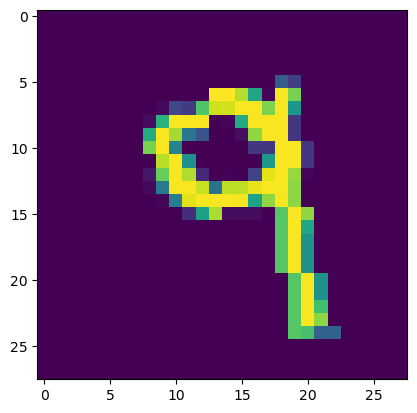

5


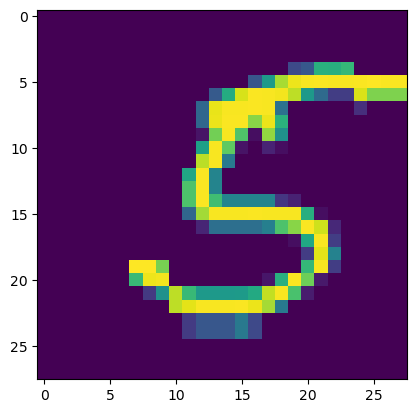

5


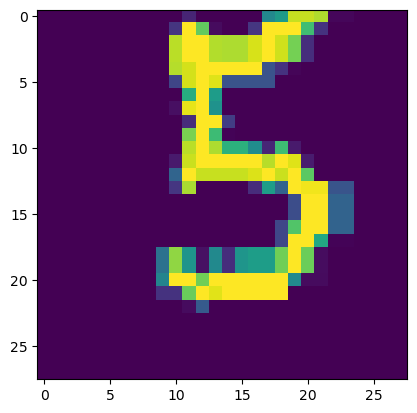

9


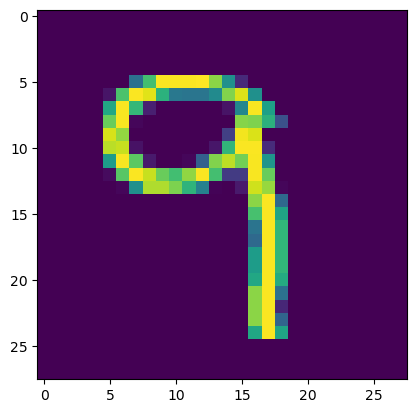

1


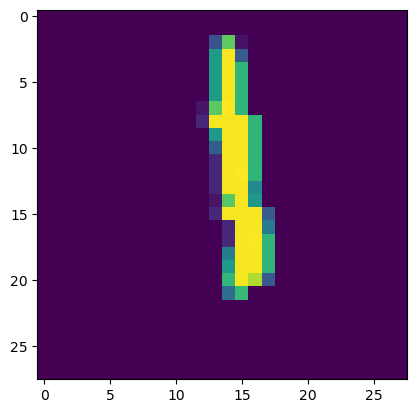


Train DataLoader Normalized
3


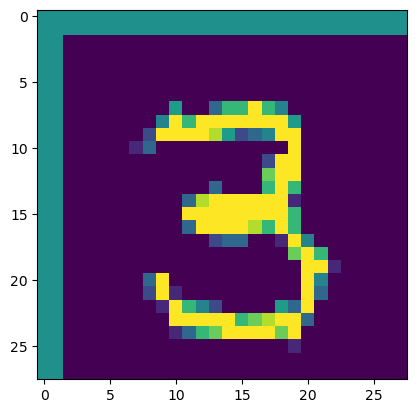

9


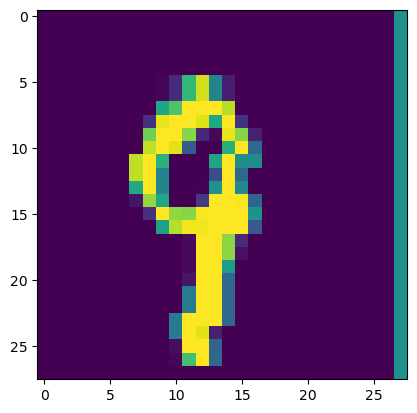

0


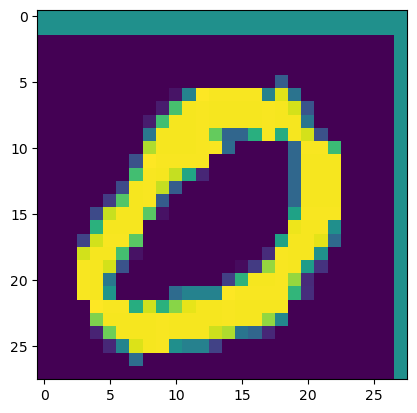

1


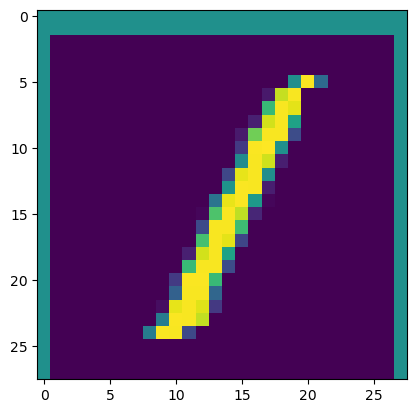

5


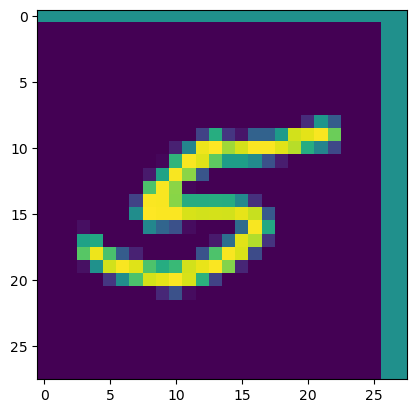

In [13]:
# Explore data
print('Train DataLoader')
show5(train_loader)
print('\nTrain DataLoader Normalized')
show5(train_loader_tuned)

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset.
Use any architecture you like. 

*Note*: If you did not flatten your tensors in your transforms or as part of your preprocessing and you are using only `Linear` layers, make sure to use the `Flatten` layer in your network!

In [19]:
# Class for the neural network
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.Convolutional_layers = nn.Sequential(nn.Conv2d(in_channels=1,out_channels=8,kernel_size=3,padding=1,stride=1),
                                                  nn.Dropout2d(0.4),
                                                  nn.MaxPool2d(kernel_size=2,stride=2),
                                                  nn.Conv2d(in_channels=8,out_channels=16,kernel_size=3,padding=1,stride=1),
                                                  nn.Dropout2d(0.2))
        
        self.Linear_layers = nn.Sequential(nn.Linear(16*14*14,784),
                                            nn.ReLU(),
                                            nn.Dropout(0.6),
                                            nn.Linear(784,196),
                                            nn.ReLU(),
                                            nn.Dropout(0.3),
                                            nn.Linear(196,49),
                                            nn.ReLU(),
                                            nn.Dropout(0.15),
                                            nn.Linear(49,10))

    def forward(self, x):
        x = self.Convolutional_layers(x)
        x = torch.flatten(x, 1) # flattening all dimensions except batch
        x = self.Linear_layers(x)
        return x

# Instantiate the net
net = Net()
net.to(device)

Net(
  (Convolutional_layers): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Dropout2d(p=0.4, inplace=False)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): Dropout2d(p=0.2, inplace=False)
  )
  (Linear_layers): Sequential(
    (0): Linear(in_features=3136, out_features=784, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.6, inplace=False)
    (3): Linear(in_features=784, out_features=196, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=196, out_features=49, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.15, inplace=False)
    (9): Linear(in_features=49, out_features=10, bias=True)
  )
)

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss **during** each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [20]:
# Optimizer
optimizer = optim.Adam(net.parameters(),lr=0.001)

# Loss function
criterion = nn.CrossEntropyLoss()
criterion.to(device)

CrossEntropyLoss()

In [21]:
epochs = 10 # The total number of iterations

train_losses = []
validation_losses = []

for epoch in range(epochs):
    # prep net for training
    net.train()
    train_loss = 0.0

    for idx, (images, labels) in enumerate(train_loader): 

        # Send these >>> To GPU
        images = images.to(device)
        labels = labels.to(device)

        # Training pass
        optimizer.zero_grad()

        # Forward pass
        output = net(images)
        loss = criterion(output, labels)

        #Backward pass
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        
    
    # prep net for evaluation
    net.eval() 
    validation_loss = 0.0
    accuracy = 0

    # Turning off the gradients when performing validation.
    # If we don't turn it off, we will comprise our networks weight entirely
    with torch.no_grad():
        for images, labels in validation_loader:

            images = images.to(device)
            labels = labels.to(device)

            output = net(images) 
            validation_loss += criterion(output, labels)

            top_prob, top_class = output.topk(1, dim=1)
            predictions = top_class == labels.view(*top_class.shape)
            accuracy += torch.mean(predictions.type(torch.FloatTensor))

    train_losses.append(train_loss/len(train_loader))
    validation_losses.append(validation_loss/len(validation_loader))

    print("Epoch: {}/{}  ".format(epoch+1, epochs),
          "Training loss: {:.4f}  ".format(train_loss/len(train_loader)),
          "Validation loss: {:.4f}  ".format(validation_loss/len(validation_loader)),
          "Validation accuracy: {:.4f}  ".format(accuracy/len(validation_loader)))
     

Epoch: 1/10   Training loss: 0.8720   Validation loss: 0.1636   Validation accuracy: 0.9548  
Epoch: 2/10   Training loss: 0.5001   Validation loss: 0.1135   Validation accuracy: 0.9684  
Epoch: 3/10   Training loss: 0.4328   Validation loss: 0.1032   Validation accuracy: 0.9682  
Epoch: 4/10   Training loss: 0.3915   Validation loss: 0.0902   Validation accuracy: 0.9723  
Epoch: 5/10   Training loss: 0.3673   Validation loss: 0.0803   Validation accuracy: 0.9765  
Epoch: 6/10   Training loss: 0.3429   Validation loss: 0.0792   Validation accuracy: 0.9773  
Epoch: 7/10   Training loss: 0.3313   Validation loss: 0.0738   Validation accuracy: 0.9769  
Epoch: 8/10   Training loss: 0.3199   Validation loss: 0.0689   Validation accuracy: 0.9783  
Epoch: 9/10   Training loss: 0.3091   Validation loss: 0.0763   Validation accuracy: 0.9765  
Epoch: 10/10   Training loss: 0.2979   Validation loss: 0.0710   Validation accuracy: 0.9785  


Plot the training loss (and validation loss/accuracy, if recorded).

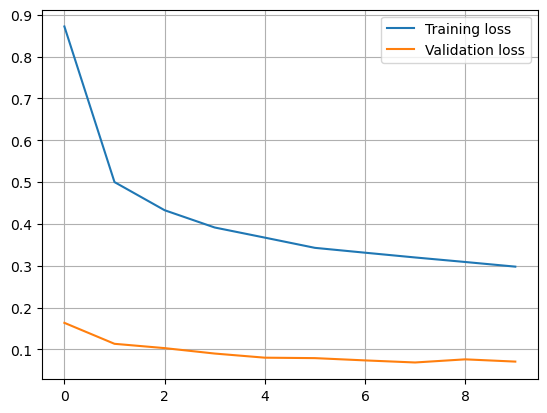

In [22]:
train_losses = torch.Tensor(train_losses).cpu()
validation_losses = torch.Tensor(validation_losses).cpu()
plt.plot(train_losses, label='Training loss')
plt.plot(validation_losses, label='Validation loss')
plt.legend()
plt.grid()

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 90%, great work, but see if you can push a bit further! 
If your accuracy is under 90%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [23]:
net.eval() 
test_loss = 0.0
accuracy = 0

# Turning off the gradients when performing validation.
# If we don't turn it off, we will comprise our networks weight entirely
with torch.no_grad():
    for images, labels in test_loader:

        images = images.to(device)
        labels = labels.to(device)

        output = net(images)
        test_loss += criterion(output, labels)

        top_prob, top_class = output.topk(1, dim=1)
        predictions = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(predictions.type(torch.FloatTensor))

print("Testing loss: {:.4f}  ".format(test_loss/len(test_loader)),
      "Test accuracy: {:.4f}  ".format(accuracy/len(test_loader)))

Testing loss: 0.0731   Test accuracy: 0.9769  


## Improving your model

Once your model is done training, try tweaking your hyperparameters and training again below to improve your accuracy on the test set!

In [24]:
# Class for the neural network
class Net_tuned(nn.Module):
    def __init__(self):
        super().__init__()
        self.Convolutional_layers = nn.Sequential(nn.Conv2d(in_channels=1,out_channels=8,kernel_size=3,padding=1,stride=1),
                                                  nn.Dropout2d(0.4),
                                                  nn.AvgPool2d(kernel_size=2,stride=2),
                                                  nn.Conv2d(in_channels=8,out_channels=16,kernel_size=3,padding=1,stride=1),
                                                  nn.Dropout2d(0.2),
                                                  nn.MaxPool2d(kernel_size=2,stride=2))
        
        self.Linear_layers = nn.Sequential(nn.Linear(16*7*7,512),
                                            nn.ReLU(),
                                            nn.Dropout(0.5),
                                            nn.Linear(512,128),
                                            nn.ReLU(),
                                            nn.Dropout(0.3),
                                            nn.Linear(128,64),
                                            nn.ReLU(),
                                            nn.Dropout(0.15),
                                            nn.Linear(64,10))

    def forward(self, x):
        x = self.Convolutional_layers(x)
        x = torch.flatten(x, 1) # flattening all dimensions except batch
        x = self.Linear_layers(x)
        return x

# Instantiate the net
net_tuned = Net_tuned()
net_tuned.to(device)

Net_tuned(
  (Convolutional_layers): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Dropout2d(p=0.4, inplace=False)
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): Dropout2d(p=0.2, inplace=False)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (Linear_layers): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=512, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.15, inplace=False)
    (9): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [25]:
# Optimizer
optimizer_tuned = optim.Adam(net_tuned.parameters(),lr=0.001)

# Loss function
criterion_tuned = nn.CrossEntropyLoss()
criterion_tuned.to(device)

CrossEntropyLoss()

In [26]:
epochs = 15 # The total number of iterations

train_losses_tuned = []
validation_losses_tuned = []

for epoch in range(epochs):
    # prep net_tuned for training
    net_tuned.train()
    train_loss = 0.0

    for idx, (images, labels) in enumerate(train_loader_tuned): 

        # Send these >>> To GPU
        images = images.to(device)
        labels = labels.to(device)

        # Training pass
        optimizer_tuned.zero_grad()

        # Forward pass
        output = net_tuned(images)
        loss = criterion_tuned(output, labels)

        #Backward pass
        loss.backward()
        optimizer_tuned.step()

        train_loss += loss.item()
        
    
    # prep net_tuned for evaluation
    net_tuned.eval() 
    validation_loss = 0.0
    accuracy = 0

    # Turning off the gradients when performing validation.
    # If we don't turn it off, we will comprise our net_tunedworks weight entirely
    with torch.no_grad():
        for images, labels in validation_loader_tuned:

            images = images.to(device)
            labels = labels.to(device)

            output = net_tuned(images) 
            validation_loss += criterion_tuned(output, labels)

            top_prob, top_class = output.topk(1, dim=1)
            predictions = top_class == labels.view(*top_class.shape)
            accuracy += torch.mean(predictions.type(torch.FloatTensor))

    train_losses_tuned.append(train_loss/len(train_loader_tuned))
    validation_losses_tuned.append(validation_loss/len(validation_loader))

    print("Epoch: {}/{}  ".format(epoch+1, epochs),
          "Training loss: {:.4f}  ".format(train_loss/len(train_loader_tuned)),
          "Validation loss: {:.4f}  ".format(validation_loss/len(validation_loader)),
          "Validation accuracy: {:.4f}  ".format(accuracy/len(validation_loader)))
     

Epoch: 1/15   Training loss: 0.7755   Validation loss: 0.1036   Validation accuracy: 0.9678  
Epoch: 2/15   Training loss: 0.3991   Validation loss: 0.0649   Validation accuracy: 0.9827  
Epoch: 3/15   Training loss: 0.3317   Validation loss: 0.0594   Validation accuracy: 0.9833  
Epoch: 4/15   Training loss: 0.2977   Validation loss: 0.0467   Validation accuracy: 0.9871  
Epoch: 5/15   Training loss: 0.2758   Validation loss: 0.0419   Validation accuracy: 0.9879  
Epoch: 6/15   Training loss: 0.2596   Validation loss: 0.0518   Validation accuracy: 0.9843  
Epoch: 7/15   Training loss: 0.2518   Validation loss: 0.0418   Validation accuracy: 0.9873  
Epoch: 8/15   Training loss: 0.2371   Validation loss: 0.0360   Validation accuracy: 0.9898  
Epoch: 9/15   Training loss: 0.2291   Validation loss: 0.0347   Validation accuracy: 0.9887  
Epoch: 10/15   Training loss: 0.2251   Validation loss: 0.0377   Validation accuracy: 0.9898  
Epoch: 11/15   Training loss: 0.2211   Validation loss: 0.0

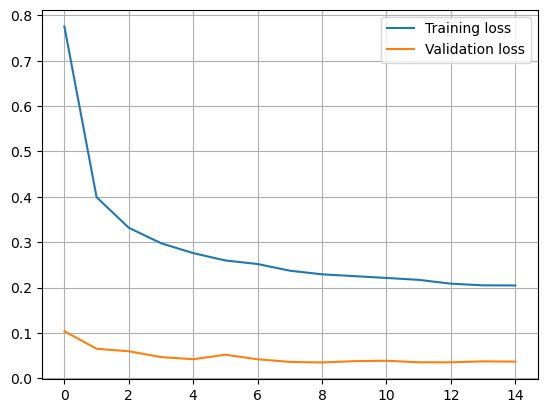

In [27]:
train_losses_tuned = torch.Tensor(train_losses_tuned).cpu()
validation_losses_tuned = torch.Tensor(validation_losses_tuned).cpu()
plt.plot(train_losses_tuned, label='Training loss')
plt.plot(validation_losses_tuned, label='Validation loss')
plt.legend()
plt.grid()

In [28]:
net_tuned.eval() 
test_loss = 0.0
accuracy = 0

# Turning off the gradients when performing validation.
# If we don't turn it off, we will comprise our networks weight entirely
with torch.no_grad():
    for images, labels in test_loader_tuned:

        images = images.to(device)
        labels = labels.to(device)

        output = net_tuned(images)
        test_loss += criterion_tuned(output, labels)

        top_prob, top_class = output.topk(1, dim=1)
        predictions = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(predictions.type(torch.FloatTensor))

print("Testing loss: {:.4f}  ".format(test_loss/len(test_loader_tuned)),
      "Test accuracy: {:.4f}  ".format(accuracy/len(test_loader_tuned)))

Testing loss: 0.0275   Test accuracy: 0.9910  


## Saving your model
Using `torch.save`, save your model for future loading.

In [29]:
torch.save(net.state_dict(),'handwritten_digit_classifier.pth')
torch.save(net_tuned.state_dict(),'handwritten_digit_classfier_tuned.pth')